In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0, na_values='?') #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0, na_values='?')
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [6]:
train.isnull().sum()
test.isnull().sum()

age                  0
workclass         1502
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1508
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     456
income               0
dtype: int64

age                 0
workclass         334
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        335
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    127
dtype: int64

### outlier

### education

In [7]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [8]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

(32561, 14)

In [19]:
pd.factorize(train['occupation'], sort=True)[1]
pd.factorize(test['occupation'], sort=True)[1]

Index(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')

Index(['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial',
       'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct',
       'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv',
       'Sales', 'Tech-support', 'Transport-moving'],
      dtype='object')

In [20]:
train['occupation']=pd.factorize(train['occupation'], sort=True)[0]
test['occupation']=pd.factorize(test['occupation'], sort=True)[0]

In [21]:
train['occupation_n_rows'] = train['occupation'].map(train.groupby('occupation').size())
test['occupation_n_rows'] = test['occupation'].map(test.groupby('occupation').size())

In [26]:
occupation_mean = train.groupby('occupation')['income'].mean()
train['occupation_mean'] = train['occupation'].map(occupation_mean)
test['occupation_mean'] = test['occupation'].map(occupation_mean)

In [22]:
train['income'].mean() 

0.242043840454528

In [23]:
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 0.242043840454528*0.8) / (n_rows + 0.8)

In [27]:
train['occupation_mean_smoothing'] = train.apply(lambda x:smoothing(x['occupation_n_rows'], x['occupation_mean']), axis=1)
test['occupation_mean_smoothing'] = test.apply(lambda x:smoothing(x['occupation_n_rows'], x['occupation_mean']), axis=1)

In [28]:
train.drop(['occupation_mean', 'occupation_n_rows'], axis=1, inplace=True)
test.drop(['occupation_mean', 'occupation_n_rows'], axis=1, inplace=True)

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [29]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num','occupation_mean_smoothing']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,True
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 9.03 s


In [30]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8663,0.9216,0.6494,0.7636,0.7015,0.6162,0.6198,2.3208
1,Light Gradient Boosting Machine,0.8668,0.9216,0.6445,0.7682,0.7007,0.6159,0.6200,0.3531
2,CatBoost Classifier,0.8680,0.9247,0.6384,0.7773,0.7006,0.6170,0.6222,13.8283
3,Gradient Boosting Classifier,0.8639,0.9197,0.6157,0.7761,0.6864,0.6010,0.6077,2.5556
4,Ada Boost Classifier,0.8558,0.9114,0.6131,0.7458,0.6728,0.5815,0.5862,0.8650
5,Linear Discriminant Analysis,0.8460,0.9000,0.5927,0.7216,0.6504,0.5529,0.5576,0.1951
6,Extra Trees Classifier,0.8356,0.8827,0.6037,0.6816,0.6400,0.5340,0.5359,0.5808
7,Random Forest Classifier,0.8418,0.8775,0.5620,0.7231,0.6322,0.5335,0.5405,0.1272


In [31]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8668,0.9222,0.6456,0.7673,0.7012,0.6164,0.6202
1,0.8621,0.9181,0.6440,0.7509,0.6934,0.6051,0.6081
2,0.8598,0.9232,0.6214,0.7559,0.6821,0.5932,0.5979
3,0.8742,0.9305,0.6434,0.7972,0.7121,0.6328,0.6388
4,0.8699,0.9246,0.6618,0.7688,0.7113,0.6279,0.6309
Mean,0.8666,0.9237,0.6433,0.7680,0.7000,0.6151,0.6192
SD,0.0052,0.0040,0.0129,0.0161,0.0113,0.0146,0.0148


In [32]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8721,0.9291,0.6533,0.7821,0.7119,0.6305,0.6348


In [33]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 49s


In [34]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [35]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [36]:
submission.to_csv('output/20201019-1.csv')

In [37]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8684,0.9187,0.6149,0.7950,0.6934,0.6114,0.6196
1,0.8637,0.9170,0.6667,0.7437,0.7031,0.6150,0.6165
2,0.8645,0.9193,0.6699,0.7446,0.7053,0.6176,0.6191
3,0.8574,0.9182,0.6299,0.7405,0.6807,0.5896,0.5928
4,0.8503,0.9045,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8652,0.9288,0.6634,0.7509,0.7045,0.6176,0.6196
6,0.8785,0.9358,0.6570,0.8056,0.7237,0.6469,0.6524
7,0.8715,0.9258,0.6570,0.7778,0.7123,0.6303,0.6340
8,0.8683,0.9231,0.6440,0.7743,0.7032,0.6195,0.6238
9,0.8754,0.9249,0.6861,0.7737,0.7273,0.6469,0.6489


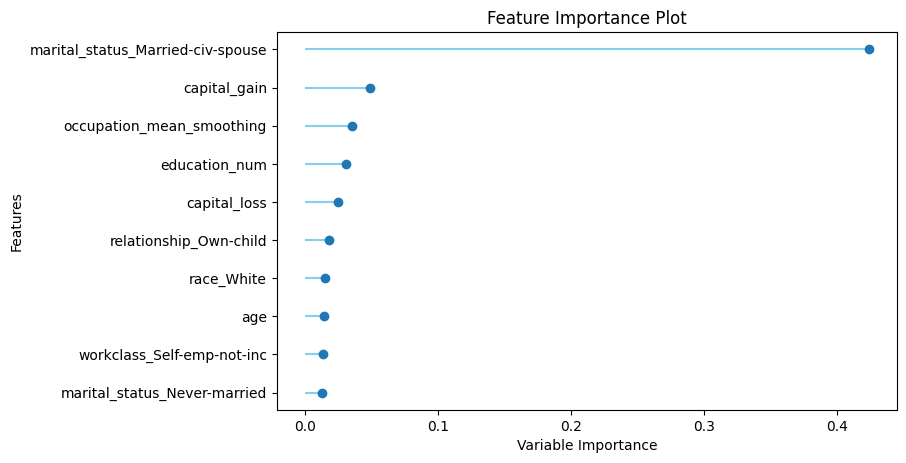

In [38]:
plot_model(estimator = xgboost, plot = 'feature')

In [39]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8677,0.9190,0.6343,0.7778,0.6988,0.6151,0.6203
1,0.8653,0.9214,0.6570,0.7546,0.7024,0.6159,0.6184
2,0.8637,0.9175,0.6699,0.7419,0.7041,0.6159,0.6172
3,0.8597,0.9161,0.6201,0.7549,0.6809,0.5921,0.5968
4,0.8542,0.9099,0.6052,0.7450,0.6679,0.5758,0.5809
5,0.8676,0.9313,0.6472,0.7692,0.7030,0.6186,0.6224
6,0.8777,0.9345,0.6505,0.8072,0.7204,0.6433,0.6495
7,0.8613,0.9201,0.6278,0.7578,0.6867,0.5987,0.6030
8,0.8738,0.9260,0.6408,0.7984,0.7110,0.6315,0.6377
9,0.8770,0.9202,0.6926,0.7754,0.7316,0.6521,0.6539


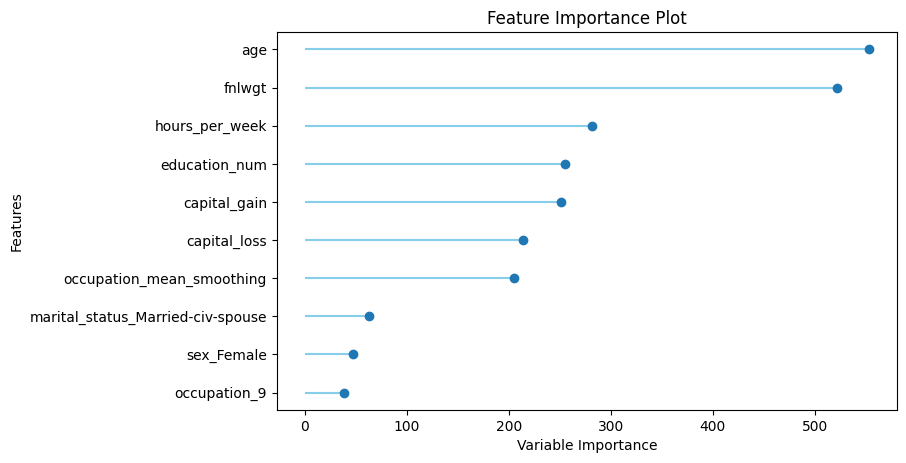

In [40]:
plot_model(estimator = lightgbm, plot = 'feature')